In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from tqdm import tqdm
import spacy
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# lemmatize = spacy.load("en_core_web_sm")


c:\Users\lukgr\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
data = pd.read_json("data/putin_complete.json")

### Preprocessing

In [3]:
stop_words = set(stopwords.words('english'))

In [5]:
transcripts = np.array(data["transcript_filtered"])
dates = data["date"].reset_index(drop=True)
punctuation = [".", ",", "?", "!", ":", "`", "'", "(", ")", "[", "]", "/", '’', "-", "’s", "\"", ";", "i", " ", "–", "%", "*", "..."]
lemmatize = spacy.load("en_core_web_sm")
transcripts_processed = {}

for id in tqdm(range(len(transcripts)), "Removing stop words..."):
    curr_date = dates[id].strftime('%Y-%m')
    speech_from_date = [
        w.lemma_.lower() for w in lemmatize(transcripts[id]) if not (w.lemma_ in stop_words or w.lemma_.lower() in punctuation or " " in w.lemma_)
    ]
    if curr_date not in transcripts_processed.keys():
        transcripts_processed[curr_date] = []
    if len(speech_from_date) > 0:
        transcripts_processed[curr_date].append(speech_from_date)


Removing stop words...: 100%|██████████| 9838/9838 [12:26<00:00, 13.18it/s] 


### EDA & Some Analysis

In [6]:
all_words = []
token_counts = []
speeches_count = 0
for k, v in transcripts_processed.items():
    if v:
        for speech in v:
            all_words += speech
            token_counts.append(len(speech))
            speeches_count += 1

word_frequencies = pd.Series(all_words).value_counts()

In [ ]:
# with open("list.txt", "w") as output:
#     output.write(str(list(word_frequencies.keys())))

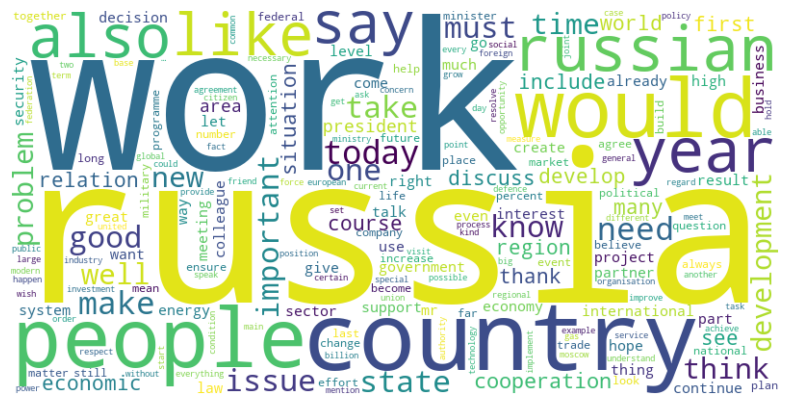

In [83]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
print(f"Average length of monthly speeches in token count: {int(np.sum(token_counts) / speeches_count)}")

Average length of monthly speeches in token count: 489


In [8]:
print(f"Average token length: {np.round(np.mean([len(word) for word in all_words]), 2)}")

Average token length: 6.41


In [139]:
all_ngrams = []

for k, v in transcripts_processed.items():
    for speech in v:
        all_ngrams += list(ngrams(speech, 5))

In [ ]:
def find_words_near_poland(ngrams):
    words_near_poland = []
    for ngram in ngrams:
        if "poland" in ngram or "polish" in ngram:
            for word in ngram:
                if not word.__eq__("poland") and not word.__eq__("polish"):
                    words_near_poland.append(word)
    
    return words_near_poland

In [141]:
# Words used near word Poland
pd.Series(find_words_near_poland(all_ngrams)).value_counts()[:10]

russian      229
russia       227
relation     156
people       151
germany      128
minister     123
republic     119
romania      119
country      117
president    112
Name: count, dtype: int64

In [12]:
words_near = []

for k, v in transcripts_processed.items():
    for speech in v:
        words_near.append(find_words_near_poland(list(ngrams(v, 5)))[:10])

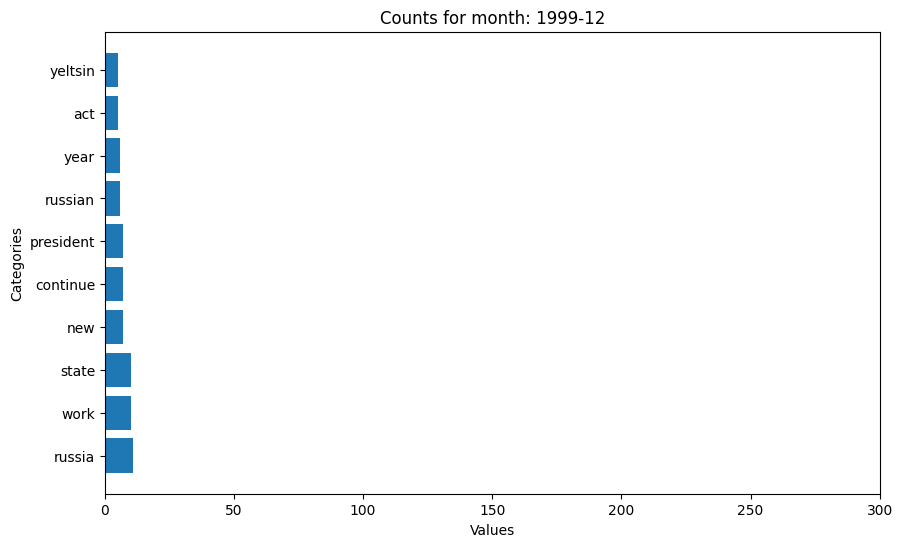

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    curr_key = list(transcripts_processed.keys())[frame]
    curr_speeches = []
    for speech in transcripts_processed[curr_key]:
        curr_speeches += speech
    counts = pd.Series(curr_speeches).value_counts()
    ax.clear()
    plt.barh(counts[:10].index, counts[:10].values)
    ax.set_xlabel("Values")
    ax.set_ylabel("Categories")
    ax.set_title(f"Counts for month: {curr_key}")
    ax.set_xlim(0, 300)

num_frames = len(transcripts_processed.keys())
ani = FuncAnimation(fig, update, frames=num_frames, repeat=True, interval=1000)

ani.save("counts.gif", writer='pillow')

In [14]:
def get_token_encounters(token):
    encounters = []
    dates = []
    for k, v in transcripts_processed.items():
        dates.append(k)
        counts_for_month = []
        for speech in v:
            counts = pd.Series(speech).value_counts()
            try:
                counts_for_month.append(counts[token])
            except:
                counts_for_month.append(0)
        encounters.append(sum(counts_for_month))
    
    return encounters, dates

def plot_counts(tokens):
    encounters, dates = get_token_encounters(tokens[0])
    for token in tokens[1:]:
        encounters_token, _ = get_token_encounters(token)
        encounters = [encounters[i] + encounters_token[i] for i in range(len(encounters))]
    plt.plot(dates, encounters, color="lightblue")
    plt.xlabel("Date")
    plt.ylabel("Counts")
    plt.title(f"Count of mentions about {tokens}")
    plt.xticks(rotation=45, ticks=range(0, len(dates), 12))
    threshold = np.quantile(encounters, 0.98)
    for i in range(len(encounters)):
        if encounters[i] > threshold:
            plt.text(i-20, encounters[i]+max(encounters)/50, dates[i], color='black')
    plt.ylim(0, max(encounters) + max(encounters)/10)
    plt.show() 

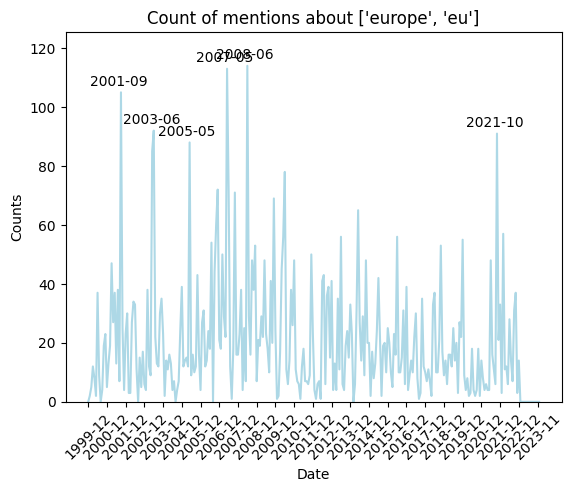

In [202]:
plot_counts(["europe", "eu"])
# plot_counts(["warsaw"])
# plot_counts(["poland", "poles", "polish", "warsaw"])

In [16]:
speeches_processed = {}
for date, value in transcripts_processed.items():
    speeches_processed[date] = []
    for speech in value:
        speeches_processed[date].append(" ".join(speech))

all_speeches = []
for k, v in speeches_processed.items():
    for speech in v:
        all_speeches.append(speech)

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(all_speeches)

In [17]:
tfidf_dict = {}
for ele1, ele2 in zip(vectorizer.get_feature_names_out(), vectorizer.idf_):
   if ele2 < 5.5:
      tfidf_dict[ele1] = np.round(ele2, 5)

In [18]:
tfidf_values = list(tfidf_dict.values())
tfidf_keys = list(tfidf_dict.keys())
sorting_perm = sorted(range(len(tfidf_values)), key=lambda i: tfidf_values[i])

# print(np.array(tfidf_values)[sorting_perm])
# print(np.array(tfidf_keys)[sorting_perm][-100:])

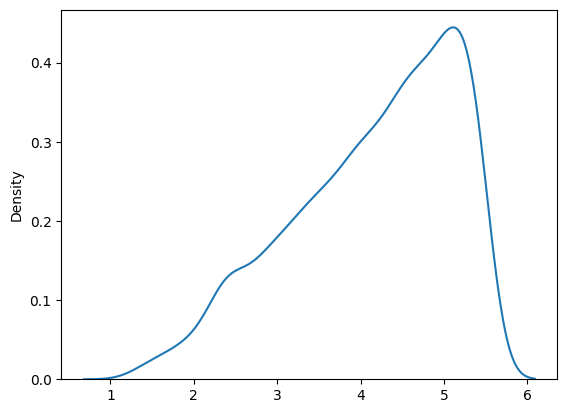

In [19]:
sns.kdeplot(np.array(tfidf_values)[sorting_perm])
plt.show()

In [203]:
split_speeches_for_bert = {}
words_list = ["europe", "eu"]
chunk_size = 256

for date, value in transcripts_processed.items():
    split_speeches_for_bert[date] = []
    for speech in value:
        if any(pol_word in speech for pol_word in words_list):
            split_speeches_for_bert[date].append([speech[i:i + chunk_size] for i in range(0, len(speech), chunk_size)])

In [206]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [77]:
sentiments_in_time = {}

for date, val in split_speeches_for_bert.items():
    if len(val) == 0:
        continue
    for speech in tqdm(val, "processing..."):
        speech_sentiments = []
        for split in speech:
            if len(split) > 100:
                inputs = tokenizer(" ".join(split), return_tensors="pt")
                with torch.no_grad():
                    speech_sentiments.append(model(**inputs).logits[0])
        if len(speech_sentiments) == 0:
            continue
        stacked_tensors = torch.stack(speech_sentiments)
        mean_x = torch.mean(stacked_tensors[:, 0])
        mean_y = torch.mean(stacked_tensors[:, 1])
        final_sentiment = model.config.id2label[0 if mean_x > mean_y else 1]

        if not date in list(sentiments_in_time.keys()):
            sentiments_in_time[date] = []
        sentiments_in_time[date].append(final_sentiment)

processing...: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


In [82]:
sentiment_dates = []
positive_sentiment_counts = []
negative_sentiment_counts = []

for date, sentiments in sentiments_in_time.items():
    sentiment_dates.append(date)
    pos_count = 0
    neg_count = 0
    for sentiment in sentiments:
        if sentiment.__eq__("POSITIVE"):
            pos_count += 1
        else:
            neg_count += 1
    positive_sentiment_counts.append(pos_count)
    negative_sentiment_counts.append(neg_count)

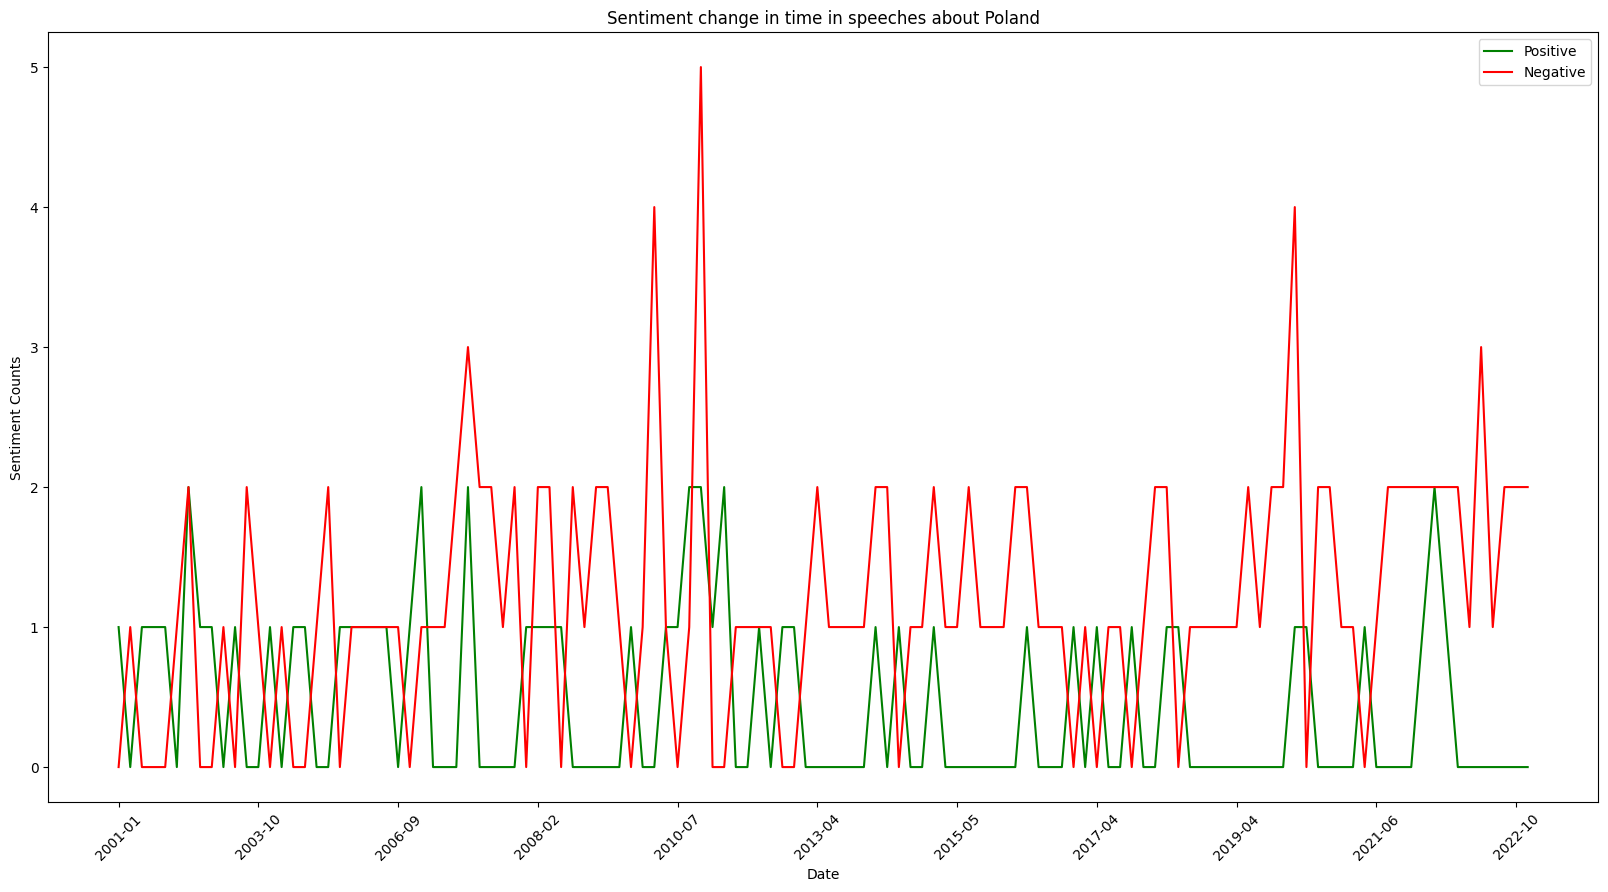

In [97]:
plt.figure(figsize=(20, 10))
plt.plot(sentiment_dates, positive_sentiment_counts, color="green", label="Positive")
plt.plot(sentiment_dates, negative_sentiment_counts, color="red", label="Negative")
plt.xlabel("Date")
plt.ylabel("Sentiment Counts")
plt.legend()
plt.title(f"Sentiment change in time in speeches about Poland")
plt.xticks(rotation=45, ticks=range(0, len(sentiment_dates), 12))
plt.show()